## [분석 목표]  : 집단행동 경향성

### 1. 패턴 기반 사용자 군 분류 (심리학 연결)  - 습관적 사용자 / 탐색적 사용자 
- 어떤 시간대/지역/경로에서 루틴화되고 있는가?  - 근거리/장거리, 출퇴근시간대, 지역+경로
- 한달간 사용률이 가장 높은 패턴은? (심리학 기반 추정)

ex. 근거리 반복 이용: 초기 습관화 단계로 해석 가능

특정 대여소의 '전환 허브' 기능 파악 → 운영 최적화 가능


In [59]:
import pandas as pd

dfs = []
for day in range(1,32):
    day_str = f"{day:02d}"   # 날짜 형식 통일 -> 00일
    df = pd.read_csv(f'C:/Users/user/Downloads/tpss_bcycl_od_statnhm_202410/tpss_bcycl_od_statnhm_202410{day_str}.csv', encoding='cp949')
    dfs.append(df)
    total_df = pd.concat(dfs, ignore_index=True)
    
print(total_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8485006 entries, 0 to 8485005
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   기준_날짜      int64  
 1   집계_기준      object 
 2   기준_시간대     int64  
 3   시작_대여소_ID  object 
 4   시작_대여소명    object 
 5   종료_대여소_ID  object 
 6   종료_대여소명    object 
 7   전체_건수      int64  
 8   전체_이용_분    float64
 9   전체_이용_거리   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 647.4+ MB
None


In [61]:
total_df.groupby('기준_날짜').size().sort_values(ascending=False)

기준_날짜
20241011    345320
20241008    334630
20241016    333973
20241017    332706
20241010    331753
20241004    330139
20241002    323739
20241007    320402
20241014    315677
20241030    309559
20241031    309158
20241025    305311
20241028    293893
20241024    293794
20241015    287369
20241021    285229
20241005    285017
20241029    284534
20241012    282940
20241009    278491
20241003    266000
20241023    265509
20241026    256376
20241013    247632
20241019    233392
20241001    232779
20241020    215148
20241027    196620
20241006    193005
20241018    144814
20241022     50097
dtype: int64

In [62]:
# 결측값 확인
total_df.isna().sum()

기준_날짜             0
집계_기준             0
기준_시간대            0
시작_대여소_ID         0
시작_대여소명        6664
종료_대여소_ID         0
종료_대여소명       37857
전체_건수             0
전체_이용_분      196147
전체_이용_거리     196147
dtype: int64

In [64]:
print(total_df.시작_대여소_ID[total_df.시작_대여소명.isna() == True].unique())
print(total_df.종료_대여소_ID[total_df.종료_대여소명.isna() == True].unique())

['ST-1050' 'ST-1289' 'ST-3191' 'ST-3273' 'ST-3190' 'ST-2426']
['X' 'ST-1289' 'ST-3191' 'ST-1050' 'ST-3273' 'ST-3190']


In [65]:
# 출발 / 도착 데이터 분리
depart_time = total_df[total_df.집계_기준 == '출발시간']  # 출발시간만 추춘
depart_time = depart_time.rename(columns={'기준_시간대': '출발시간'})  # 컬럼명 재정의-> 출발시간
arrive_time = total_df[total_df.집계_기준 == '도착시간']  # 도착시간만 추춘
arrive_time = arrive_time.rename(columns={'기준_시간대': '도착시간'})  # 컬럼명 재정의-> 도착시간

# 시간 형식으로 변경
def time_format(x):       # 1320 -> 13:20 형식으로 바꾸기
    s = f"{int(x):04d}"   # 빈자리 0으로 채워서 4글자로 만들기   ex) 0025
    return s[:-2] + ":" + s[-2:]    # 시간 : 분    ex) 00:25
depart_time.출발시간 = depart_time.출발시간.apply(time_format)  # 함수 적용
arrive_time.도착시간 = arrive_time.도착시간.apply(time_format)  # 함수 적용
depart_time['기준_날짜'] = depart_time.기준_날짜.astype(str)    # 년월일 -> 문자열로 변경
arrive_time['기준_날짜'] = arrive_time.기준_날짜.astype(str)    # 년월일 -> 문자열로 변경
depart_time['출발시간'] = pd.to_datetime(depart_time.기준_날짜 + ' ' + depart_time.출발시간 , format='%Y%m%d %H:%M')  # datetime 형식으로 변경
arrive_time['도착시간'] = pd.to_datetime(arrive_time.기준_날짜 + ' ' + arrive_time.도착시간 , format='%Y%m%d %H:%M')  # datetime 형식으로 변경
# depart_time['출발시간'] = depart_time.출발시간.dt.time   # time형식만 남기기
# arrive_time['도착시간'] = arrive_time.도착시간.dt.time   # time형식만 남기기


# 출발 시간과 도착 시간 한 행에 표시하기 
merge_columns = ['기준_날짜', '시작_대여소_ID', '종료_대여소_ID', '전체_건수', '전체_이용_분', '전체_이용_거리']  # 합병의 기준이 되는 컬럼들
arrive_df = arrive_time[merge_columns + ['도착시간']]   # 합병 기준 + 도착시간만 추출한 df
df_2410 = depart_time.merge(arrive_df, on = merge_columns, how='left')
print(df_2410)

            기준_날짜 집계_기준                출발시간 시작_대여소_ID     시작_대여소명 종료_대여소_ID  \
0        20241001  출발시간 2024-10-01 13:20:00   ST-1352  발산1동_065_1   ST-1064   
1        20241001  출발시간 2024-10-01 00:25:00   ST-2482  방화1동_023_1    ST-824   
2        20241001  출발시간 2024-10-01 00:25:00   ST-2482  방화1동_023_1    ST-824   
3        20241001  출발시간 2024-10-01 00:25:00   ST-2482  방화1동_023_1    ST-824   
4        20241001  출발시간 2024-10-01 17:30:00   ST-1063  가양1동_016_1    ST-975   
...           ...   ...                 ...       ...         ...       ...   
4340678  20241031  출발시간 2024-10-31 19:15:00   ST-1818   혜화동_032_1   ST-1779   
4340679  20241031  출발시간 2024-10-31 21:40:00   ST-3046   종암동_046_1   ST-2504   
4340680  20241031  출발시간 2024-10-31 17:50:00   ST-2761  신정4동_005_1    ST-428   
4340681  20241031  출발시간 2024-10-31 18:55:00   ST-1971   여의동_002_5     ST-36   
4340682  20241031  출발시간 2024-10-31 14:50:00     ST-47   여의동_001_1   ST-2648   

            종료_대여소명  전체_건수  전체_이용_분  전체_이용_거리      

In [66]:
# 동일 대여 이벤트에 정확히 매칭되도록 필터링
df_2410.전체_이용_분 = pd.to_timedelta(df_2410.전체_이용_분, unit='m')
df_2410 = df_2410[(df_2410.출발시간 <= df_2410.도착시간) &
                                (df_2410.출발시간 + df_2410.전체_이용_분 >= df_2410.도착시간)]
df_2410 = df_2410.drop(columns='집계_기준')
df_2410

,기준_날짜,출발시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,도착시간
4,20241001,2024-10-01 17:30:00,ST-1063,가양1동_016_1,ST-975,방화1동_040_2,1,0 days 00:05:00,1073.0,2024-10-01 17:35:00
6,20241001,2024-10-01 19:00:00,ST-3094,등촌1동_003_1,ST-2487,등촌1동_033_1,1,0 days 00:03:00,366.0,2024-10-01 19:00:00
9,20241001,2024-10-01 18:05:00,ST-344,성산2동_076_2,ST-2974,상암동_024_4,2,0 days 00:48:00,5635.0,2024-10-01 18:30:00
10,20241001,2024-10-01 23:35:00,ST-919,고척1동_001_2,ST-1219,구로1동_002_1,1,0 days 00:09:00,1260.0,2024-10-01 23:40:00
11,20241001,2024-10-01 14:40:00,ST-2177,한강로동_012_1,ST-699,노량진2동_020_1,1,0 days 01:00:00,11100.0,2024-10-01 15:40:00
...,...,...,...,...,...,...,...,...,...,...
4340666,20241031,2024-10-31 08:30:00,ST-512,방화1동_048_2,ST-1676,발산1동_057_3,1,0 days 00:10:00,1581.0,2024-10-31 08:40:00
4340676,20241031,2024-10-31 14:40:00,ST-760,방배4동_032_1,ST-760,방배4동_032_1,1,0 days 00:52:00,440.0,2024-10-31 15:30:00
4340680,20241031,2024-10-31 17:50:00,ST-2761,신정4동_005_1,ST-428,신정6동_002_4,1,0 days 00:06:00,788.0,2024-10-31 17:55:00
4340681,20241031,2024-10-31 18:55:00,ST-1971,여의동_002_5,ST-36,신촌동_024_5,1,0 days 00:17:00,3264.0,2024-10-31 19:10:00


In [75]:
pip install holidays


   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------  1.0/1.0 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 4.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
# 평일/휴일 분류
import holidays
holidays_24 = holidays.KR(years=2024)
df_2410['day_num'] = df_2410.출발시간.dt.dayofweek
df_2410['holiday'] = df_2410.출발시간.isin(holidays_24)

def classify_day(row):
    if (row['holiday'] == True) or (row['day_num'] >= 5):
         return '휴일'
    else: 
        return '평일'

df_2410['평일여부'] = df_2410.apply(classify_day, axis=1)
print(df_2410)



C:\Users\user\AppData\Local\Temp\ipykernel_13540\636771278.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_2410['holiday'] = df_2410.출발시간.isin(holidays_24)


            기준_날짜                출발시간 시작_대여소_ID     시작_대여소명 종료_대여소_ID  \
4        20241001 2024-10-01 17:30:00   ST-1063  가양1동_016_1    ST-975   
6        20241001 2024-10-01 19:00:00   ST-3094  등촌1동_003_1   ST-2487   
9        20241001 2024-10-01 18:05:00    ST-344  성산2동_076_2   ST-2974   
10       20241001 2024-10-01 23:35:00    ST-919  고척1동_001_2   ST-1219   
11       20241001 2024-10-01 14:40:00   ST-2177  한강로동_012_1    ST-699   
...           ...                 ...       ...         ...       ...   
4340666  20241031 2024-10-31 08:30:00    ST-512  방화1동_048_2   ST-1676   
4340676  20241031 2024-10-31 14:40:00    ST-760  방배4동_032_1    ST-760   
4340680  20241031 2024-10-31 17:50:00   ST-2761  신정4동_005_1    ST-428   
4340681  20241031 2024-10-31 18:55:00   ST-1971   여의동_002_5     ST-36   
4340682  20241031 2024-10-31 14:50:00     ST-47   여의동_001_1   ST-2648   

             종료_대여소명  전체_건수         전체_이용_분  전체_이용_거리                도착시간  \
4         방화1동_040_2      1 0 days 00:05:00   

평일여부
평일    1577107
휴일     469898
dtype: int64


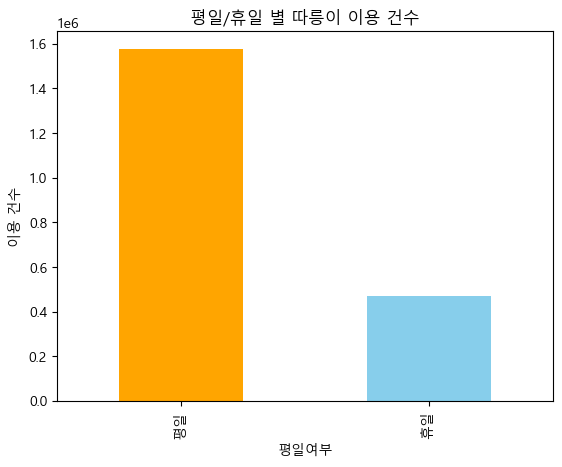

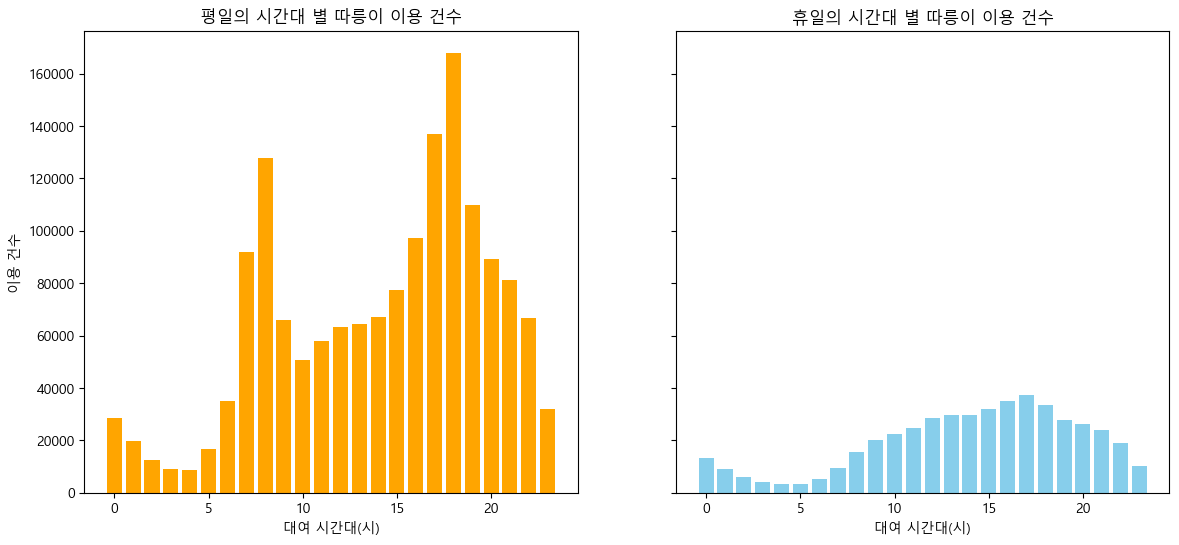

In [107]:
# 평일/휴일별 이용 건수 탐색
week_use = df_2410.groupby('평일여부').size()
print(week_use)   # 평일 > 휴일

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')

week_use.plot(kind='bar', color=['orange','skyblue'])
plt.title('평일/휴일 별 따릉이 이용 건수')
plt.ylabel('이용 건수')
plt.show()

#평일여부에 따른 시간대별 이용 건수 탐색
df_2410['hour'] = df_2410.출발시간.dt.hour
week_hour_group = df_2410.groupby(['평일여부','hour']).size()

# 시각화
weekday_counts = week_hour_group.loc['평일']
weekend_counts = week_hour_group.loc['휴일']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
axes[0].bar(weekday_counts.index, weekday_counts.values, color = 'orange')
axes[0].set_title('평일의 시간대 별 따릉이 이용 건수')
axes[0].set_xlabel('대여 시간대(시)')
axes[0].set_ylabel('이용 건수')

axes[1].bar(weekend_counts.index, weekend_counts.values, color = 'skyblue')
axes[1].set_title('휴일의 시간대 별 따릉이 이용 건수')
axes[1].set_xlabel('대여 시간대(시)')

plt.show()

# 10만건 이상인 시간대: 오전 7~8시, 오후 3~9시
# 최고 피크시간대: 18시 
# => 17시부터 시작해서 퇴근시간에  가장 많이 몰림, 21시까지 많은 사용량이 몰리는것을 보면 귀가시간에 따릉이 사용률 증가 경향

In [126]:
weekday_counts

hour
0      28641
1      19606
2      12530
3       9064
4       8818
5      16586
6      35037
7      91854
8     127792
9      65757
10     50506
11     57947
12     63244
13     64324
14     67136
15     77374
16     97247
17    137085
18    167954
19    109899
20     89177
21     81009
22     66613
23     31907
dtype: int64

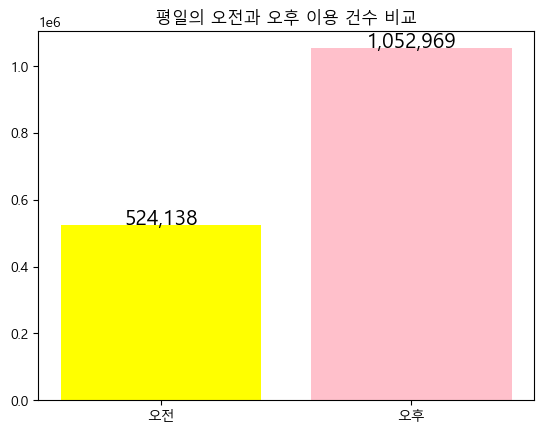

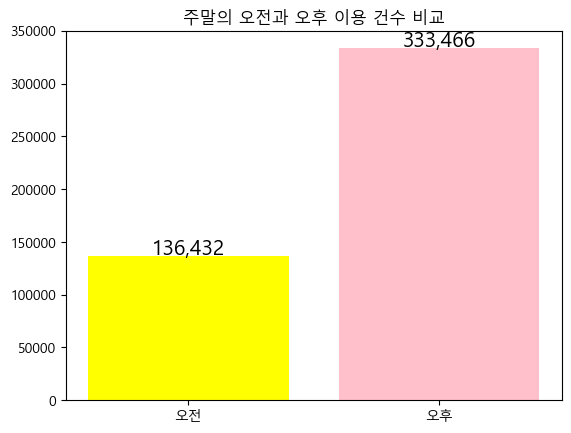

In [131]:
# 평일의 오전과 오후 이용 건수 비교
weekday_morning = weekday_counts.iloc[:12]  # 평일 오전
weekday_noon = weekday_counts.iloc[12:]     # 평일 오후
week_mornig_sum = weekday_mornig.sum()
week_noon_sum = weekday_noon.sum()

plt.bar('오전', week_mornig_sum, color='yellow')
plt.bar('오후', week_noon_sum, color='pink')
plt.title('평일의 오전과 오후 이용 건수 비교')
plt.text('오전', week_mornig_sum + 1500, f'{week_mornig_sum:,}', ha='center', fontsize=15)
plt.text('오후', week_noon_sum + 1500, f'{week_noon_sum:,}', ha='center', fontsize=15)
plt.show()

# 주말의 오전과 오후 이용 건수 비교
weekend_morning = weekend_counts.iloc[:12]  # 평일 오전
weekend_noon = weekend_counts.iloc[12:]     # 평일 오후
end_morning_sum = weekend_morning.sum()
end_noon_sum = weekend_noon.sum()

plt.bar('오전', end_morning_sum, color='yellow')
plt.bar('오후', end_noon_sum, color='pink')
plt.title('주말의 오전과 오후 이용 건수 비교')
plt.text('오전', end_mornig_sum + 1500, f'{end_mornig_sum:,}', ha='center', fontsize=15)
plt.text('오후', end_noon_sum + 1500, f'{end_noon_sum:,}', ha='center', fontsize=15)
plt.show()

In [3]:
# 대여소 정보 불러오기
station_df = pd.read_csv('C:/Users/user/Downloads/Seoul_bcycl_masterinfo.csv', encoding='cp949')
station_df.head()

,대여소_ID,주소1,주소2,위도,경도
0,ST-999,서울특별시 양천구 목동서로 280,목동아파트 8단지 상가동,0.000000,0.000000
1,ST-998,서울특별시 양천구 목동서로 130,목동아파트 4단지 상가동,0.000000,0.000000
2,ST-997,서울특별시 양천구 목동중앙로 49,목동3단지 시내버스정류장,37.534390,126.869598
3,ST-996,서울특별시 양천구 남부순환로88길5-16,양강중학교앞 교차로,37.524334,126.850548
4,ST-995,서울특별시 양천구 중앙로 153 공중화장실,NaN,37.510597,126.857323


In [4]:
# 위도,경도 == 0인 대여소는 현재 사라진 대여소 -> 해당ID 삭제
used_station_df = station_df[(station_df.위도 != 0) & (station_df.경도 != 0)]
used_station_df

,대여소_ID,주소1,주소2,위도,경도
2,ST-997,서울특별시 양천구 목동중앙로 49,목동3단지 시내버스정류장,37.534390,126.869598
3,ST-996,서울특별시 양천구 남부순환로88길5-16,양강중학교앞 교차로,37.524334,126.850548
4,ST-995,서울특별시 양천구 중앙로 153 공중화장실,NaN,37.510597,126.857323
5,ST-994,서울특별시 양천구 목동서로161,SBS방송국,37.529163,126.872749
6,ST-993,서울특별시 양천구 신월로 342-1 구두수선대19,NaN,37.521511,126.857384
...,...,...,...,...,...
3363,ST-1003,서울특별시 양천구 화곡로 59,신월동 이마트,37.539551,126.828300
3364,ST-1002,서울특별시 양천구 목동동로 316-6,서울시 도로환경관리센터,37.529900,126.876541
3366,ST-1000,서울특별시 양천구 신정동 236,서부식자재마트 건너편,37.510380,126.866798
3367,ST-100,서울특별시 광진구 아차산로 262,더샵스타시티 C동 앞,37.536667,127.073593


In [5]:
# 시작_대여소명 채우기

# 주소1, 주소2  합치기
used_station_df['주소'] = used_station_df.주소1 + used_station_df.주소2.fillna('')   # 주소2의 결측치는 공백으로 대체
print(used_station_df)

# station_df에서 대여소명 불러오기
df_2410 = df_2410.merge(
                            used_station_df[['대여소_ID', '주소']].rename(columns = {'대여소_ID': '시작_대여소_ID','주소':'출발_주소'}), 
                            on = '시작_대여소_ID', 
                            how = 'left')

# 종료_대여소명 채우기

# station_df에서 대여소명 불러오기
df_2410 = df_2410.merge(
                            used_station_df[['대여소_ID', '주소']].rename(columns = {'대여소_ID': '종료_대여소_ID','주소':'도착_주소'}), 
                            on = '종료_대여소_ID', 
                            how = 'left')
df_2410

C:\Users\user\AppData\Local\Temp\ipykernel_13540\4087600352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_station_df['주소'] = used_station_df.주소1 + used_station_df.주소2.fillna('')   # 주소2의 결측치는 공백으로 대체


       대여소_ID                          주소1            주소2         위도  \
2      ST-997           서울특별시 양천구 목동중앙로 49  목동3단지 시내버스정류장  37.534390   
3      ST-996       서울특별시 양천구 남부순환로88길5-16     양강중학교앞 교차로  37.524334   
4      ST-995      서울특별시 양천구 중앙로 153 공중화장실            NaN  37.510597   
5      ST-994            서울특별시 양천구 목동서로161         SBS방송국  37.529163   
6      ST-993  서울특별시 양천구 신월로 342-1 구두수선대19            NaN  37.521511   
...       ...                          ...            ...        ...   
3363  ST-1003             서울특별시 양천구 화곡로 59        신월동 이마트  37.539551   
3364  ST-1002         서울특별시 양천구 목동동로 316-6   서울시 도로환경관리센터  37.529900   
3366  ST-1000            서울특별시 양천구 신정동 236    서부식자재마트 건너편  37.510380   
3367   ST-100           서울특별시 광진구 아차산로 262    더샵스타시티 C동 앞  37.536667   
3368    ST-10             서울특별시 마포구 양화로 93            427  37.552746   

              경도                                주소  
2     126.869598   서울특별시 양천구 목동중앙로 49목동3단지 시내버스정류장  
3     126.850548  서울특별시 양천구 남

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,출발_주소,도착_주소
0,20241001,출발시간,1320,ST-1352,발산1동_065_1,ST-1064,발산1동_056_1,1,3.0,530.0,서울특별시 강서구 내발산동 751-3,서울특별시 강서구 마곡동 728-168마곡역7번출구
1,20241001,출발시간,25,ST-2482,방화1동_023_1,ST-824,방화1동_008_1,1,2.0,330.0,서울특별시 강서구 방화대로319,서울특별시 강서구 양천로24길 13 마곡센트레빌
2,20241001,출발시간,1730,ST-1063,가양1동_016_1,ST-975,방화1동_040_2,1,5.0,1073.0,서울특별시 강서구 공항대로 163 마곡역(5호선),서울특별시 강서구 마곡서1로 111-12신방화역환승주차장
3,20241001,출발시간,1145,ST-281,양평1동_008_1,ST-2820,문래동_025_1,1,5.0,897.0,서울특별시 영등포구 양평동3가 14-1양평우림 이비즈센타 앞,서울특별시 영등포구 영등포구 선유로9길 30
4,20241001,출발시간,1900,ST-3094,등촌1동_003_1,ST-2487,등촌1동_033_1,1,3.0,366.0,서울특별시 강서구 화곡로 416 가양역 더스카이밸리5차 지식산업센터,서울특별시 강서구 공항대로45길68-6
...,...,...,...,...,...,...,...,...,...,...,...,...
232774,20241001,도착시간,1905,ST-632,독산1동_026_3,ST-1148,독산1동_018_1,1,39.0,16150.0,서울특별시 금천구 독산동독산동 1086 (금천교 사거리 독산근린공원 입구),서울특별시 금천구 독산동 1091
232775,20241001,도착시간,2145,ST-282,양평1동_011_1,ST-1677,당산1동_020_1,1,249.0,2668.0,서울특별시 영등포구 양평동3가 60-1한국연예사관 건물 앞,서울특별시 영등포구 당산로31길 32쌍용예가(구청별관) 101동 인근
232776,20241001,도착시간,2035,ST-66,여의동_006_16,ST-3204,영등포동_053_2,1,41.0,3357.0,서울특별시 영등포구 국제금융로8길 2NH농협은행 앞,서울특별시 영등포구 경인로 900 여의도더리브스타일
232777,20241001,도착시간,1725,ST-1539,양평2동_029_1,ST-3212,당산1동_009_1,1,11.0,1287.0,서울특별시 영등포구 선유로 213선유중학교 정문,서울특별시 영등포구 당산로 83


In [67]:
df_2410.groupby('시작_대여소_ID').size().sort_values(ascending=False)

시작_대여소_ID
ST-2031    9190
ST-2905    5850
ST-891     5329
ST-99      5267
ST-2045    4986
           ... 
ST-1312       4
ST-2683       3
ST-3082       2
ST-2426       1
ST-1750       1
Length: 2750, dtype: int64